In [ ]:
# https://github.com/mcneela/Sobolev

In [2]:
import numpy as np
import matplotlib
import matplotlib.pyplot as plt
matplotlib.rcParams.update({'font.size': 16})

In [3]:
import tensorflow as tf

In [4]:
import sklearn.preprocessing

In [5]:
import wispy.callbacks

In [6]:
from scipy.interpolate import InterpolatedUnivariateSpline as IUS

In [7]:
import wispy.mscalev5

In [8]:
import pugna.activations
from tensorflow.keras.utils import get_custom_objects
get_custom_objects().update({'s2relu': pugna.activations.s2relu})

In [9]:
!ls training_data

alpha.npy  amp_22.npy coords.npy phi_21.npy times.npy
amp_21.npy beta.npy   gamma.npy  phi_22.npy


In [10]:
def get_derivative(t, A):
    return np.array([IUS(t, a).derivative()(t) for a in A])

In [11]:
def load_data(name):
    times = np.load("training_data/times.npy")
    coords = np.load("training_data/coords.npy").T
    val_coords = np.load("validation_data/coords.npy").T
    y = np.load(f"training_data/{name}.npy")
    y_val = np.load(f"training_data/{name}.npy")

    times = times[:, np.newaxis]
    scaler = sklearn.preprocessing.MinMaxScaler()
    scaler.fit(times)
    times_scaled = scaler.transform(times)
    
    
    dy = get_derivative(times_scaled[:,0], y)
    dy_val = get_derivative(times_scaled[:,0], y_val)
    
    return times, times_scaled, coords, val_coords, y, y_val, dy, dy_val

In [12]:
# times = np.load("training_data/times.npy")
# coords = np.load("training_data/coords.npy").T
# phi_22 = np.load("training_data/phi_22.npy")
# amp_22 = np.load("training_data/amp_22.npy")
# beta = np.load("training_data/beta.npy")
# val_phi_22 = np.load("validation_data/phi_22.npy")
# val_amp_22 = np.load("validation_data/amp_22.npy")
# val_beta = np.load("validation_data//beta.npy")
# val_coords = np.load("validation_data/coords.npy").T

In [13]:
times, times_scaled, coords, val_coords, y, y_val, dy, dy_val = load_data('beta')

In [14]:
times.shape

(1219, 1)

In [15]:
# this will require a custom model
# and let's keep this simple and just use time
# as the input and just fit one waveform

# https://www.tensorflow.org/guide/keras/customizing_what_happens_in_fit

# https://gitlab.com/SpaceTimeKhantinuum/ml/-/blob/master/nn-fitting/derivative/initial.ipynb

In [16]:
# X_train = times.copy()
X_train = times_scaled.copy()
Y_train = y.copy()[0][:,np.newaxis]
Y_val = y_val.copy()[0][:,np.newaxis]

dy_train = dy.copy()[0][:,np.newaxis]

In [591]:
# model_params=dict(
#     input_shape=X_train.shape[1],
#     output_shape=Y_train.shape[1],
#     units=[128,128],
#     activation="s2relu",
#     scale_activation="s2relu",
#     n_blocks=[1,1],
#     scales=[1,10],
#     layers_per_block=3,
#     scale_dimension=0,
#     dtype=None,
#     skip_connection=False,
#     skip_connection_dense=False,
#     final_dense=False,
# )

In [592]:
# model = wispy.mscalev5.build_model(**model_params)

In [548]:
model_params = dict(
    input_shape=X_train.shape[1],
    output_shape=Y_train.shape[1],
    units=128,
    activation='s2relu',
    n_hidden_layers=4)

In [549]:
def build_model(input_shape, output_shape, units, activation, n_hidden_layers):
    
    input_layer = tf.keras.Input(shape=(input_shape,))
    x = input_layer
    for i in range(n_hidden_layers):
        x = tf.keras.layers.Dense(units, activation=activation)(x)
    output_layer = tf.keras.layers.Dense(output_shape)(x)
    
    return tf.keras.models.Model(inputs=input_layer, outputs=output_layer)

In [550]:
model = build_model(**model_params)

In [160]:
model.compile(optimizer=tf.keras.optimizers.Adam(1e-3), loss='mse')

In [161]:
%%time
history = model.fit(X_train, Y_train, epochs=500, verbose=0)

CPU times: user 31.9 s, sys: 8.44 s, total: 40.4 s
Wall time: 15.9 s


In [162]:
history.history['loss'][-1]

9.701441285869805e-07

In [163]:
yhat = model.predict(X_train)

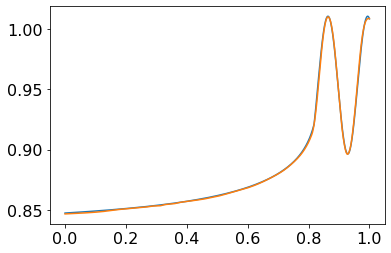

In [164]:
plt.figure()
plt.plot(X_train, Y_train)
plt.plot(X_train, yhat)

In [165]:
# https://gitlab.com/SpaceTimeKhantinuum/ml/-/blob/master/nn-fitting/derivative/initial.ipynb
def compute_gradient_from_model(x, model):
    """
    derivative of model
    https://www.tensorflow.org/guide/autodiff
    https://stackoverflow.com/a/59147703/12840171
    """
    x = tf.convert_to_tensor(x)

    with tf.GradientTape() as tape:
        tape.watch(x)
#         y = model(x, training=False)
        y = model(x)

    dy_dx = tape.gradient(y, x)
    
    return dy_dx

In [166]:
d_yhat = compute_gradient_from_model(X_train, model)
d_yhat = tf.transpose(d_yhat)

In [167]:
d_yhat.shape

TensorShape([1, 1219])

In [168]:
dy[0]

array([ 0.01534815,  0.01536892,  0.01539003, ..., -0.52603006,
       -0.62873089, -0.73058146])

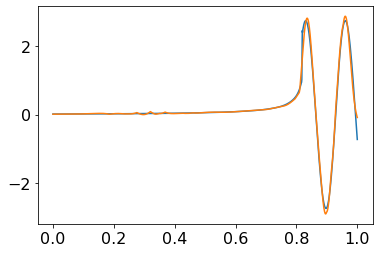

In [169]:
plt.figure()
plt.plot(X_train, dy[0])
plt.plot(X_train, d_yhat[0])

# adding derivative as a term in loss

In [156]:
# https://www.tensorflow.org/guide/keras/customizing_what_happens_in_fit 

In [276]:
loss_tracker = tf.keras.metrics.Mean(name="loss")

class CustomModel(tf.keras.Model):

    def train_step(self, data):
        # Unpack the data. Its structure depends on your model and
        # on what you pass to `fit()`.
#         x, y = data
#         tf.print(y)
        x, ys = data
#         tf.print(ys)
#         tf.print(ys[...,0])
#         tf.print(ys[...,1])
        y = ys[...,0][tf.newaxis,:]
        dy = ys[...,1][tf.newaxis,:]
#         tf.print(y)
#         dy = ys[...,1]
        
#         tf.print(y)

        with tf.GradientTape() as tape:
#             tape.watch(x)
            y_pred = self(x, training=True)  # Forward pass
            loss_y = tf.keras.losses.mean_squared_error(y, y_pred)
            
#             derivative of prediction
            d_y_pred = tape.gradient(y_pred, x)
        
            loss_dy = tf.keras.losses.mean_squared_error(y, d_y_pred)

            loss = loss_y #+ loss_dy

        # Compute gradients
        trainable_vars = self.trainable_variables
        gradients = tape.gradient(loss, trainable_vars)
        # Update weights
        self.optimizer.apply_gradients(zip(gradients, trainable_vars))

        # Compute our own metrics
        loss_tracker.update_state(loss)
        return {"loss": loss_tracker.result()}
    
    

In [277]:
def build_custom_model(input_shape, output_shape, units, activation, n_hidden_layers):
    
    input_layer = tf.keras.Input(shape=(input_shape,))
    x = input_layer
    for i in range(n_hidden_layers):
        x = tf.keras.layers.Dense(units, activation=activation)(x)
    output_layer = tf.keras.layers.Dense(output_shape)(x)
    
    return CustomModel(inputs=input_layer, outputs=output_layer)

In [278]:
custom_model_params = dict(
    input_shape=X_train.shape[1],
    output_shape=1,
    units=128,
    activation='s2relu',
    n_hidden_layers=4)

In [279]:
custom_model = build_custom_model(**custom_model_params)

In [280]:
custom_model.compile(optimizer=tf.keras.optimizers.Adam(1e-3), loss='mse')

In [281]:
# 1st col = y
# 2nd col = dy
Y_train_new = np.column_stack((Y_train, dy_train))
# Y_train_new = Y_train.copy()

In [282]:
Y_train_new.shape

(1219, 2)

In [283]:
dy_train.shape

(1219, 1)

In [284]:
%%time
custom_history = custom_model.fit(X_train, Y_train_new, epochs=500, verbose=0, batch_size=1219, shuffle=True)

ValueError: in user code:

    /Users/spx8sk/anaconda3/envs/wispy/lib/python3.7/site-packages/tensorflow/python/keras/engine/training.py:805 train_function  *
        return step_function(self, iterator)
    /Users/spx8sk/anaconda3/envs/wispy/lib/python3.7/site-packages/tensorflow/python/keras/engine/training.py:795 step_function  **
        outputs = model.distribute_strategy.run(run_step, args=(data,))
    /Users/spx8sk/anaconda3/envs/wispy/lib/python3.7/site-packages/tensorflow/python/distribute/distribute_lib.py:1259 run
        return self._extended.call_for_each_replica(fn, args=args, kwargs=kwargs)
    /Users/spx8sk/anaconda3/envs/wispy/lib/python3.7/site-packages/tensorflow/python/distribute/distribute_lib.py:2730 call_for_each_replica
        return self._call_for_each_replica(fn, args, kwargs)
    /Users/spx8sk/anaconda3/envs/wispy/lib/python3.7/site-packages/tensorflow/python/distribute/distribute_lib.py:3417 _call_for_each_replica
        return fn(*args, **kwargs)
    /Users/spx8sk/anaconda3/envs/wispy/lib/python3.7/site-packages/tensorflow/python/keras/engine/training.py:788 run_step  **
        outputs = model.train_step(data)
    <ipython-input-276-7b67f7ac1c80>:29 train_step
        loss_dy = tf.keras.losses.mean_squared_error(y, d_y_pred)
    /Users/spx8sk/anaconda3/envs/wispy/lib/python3.7/site-packages/tensorflow/python/util/dispatch.py:201 wrapper
        return target(*args, **kwargs)
    /Users/spx8sk/anaconda3/envs/wispy/lib/python3.7/site-packages/tensorflow/python/keras/losses.py:1196 mean_squared_error
        y_pred = ops.convert_to_tensor_v2_with_dispatch(y_pred)
    /Users/spx8sk/anaconda3/envs/wispy/lib/python3.7/site-packages/tensorflow/python/util/dispatch.py:201 wrapper
        return target(*args, **kwargs)
    /Users/spx8sk/anaconda3/envs/wispy/lib/python3.7/site-packages/tensorflow/python/framework/ops.py:1405 convert_to_tensor_v2_with_dispatch
        value, dtype=dtype, dtype_hint=dtype_hint, name=name)
    /Users/spx8sk/anaconda3/envs/wispy/lib/python3.7/site-packages/tensorflow/python/framework/ops.py:1415 convert_to_tensor_v2
        as_ref=False)
    /Users/spx8sk/anaconda3/envs/wispy/lib/python3.7/site-packages/tensorflow/python/profiler/trace.py:163 wrapped
        return func(*args, **kwargs)
    /Users/spx8sk/anaconda3/envs/wispy/lib/python3.7/site-packages/tensorflow/python/framework/ops.py:1540 convert_to_tensor
        ret = conversion_func(value, dtype=dtype, name=name, as_ref=as_ref)
    /Users/spx8sk/anaconda3/envs/wispy/lib/python3.7/site-packages/tensorflow/python/framework/constant_op.py:339 _constant_tensor_conversion_function
        return constant(v, dtype=dtype, name=name)
    /Users/spx8sk/anaconda3/envs/wispy/lib/python3.7/site-packages/tensorflow/python/framework/constant_op.py:265 constant
        allow_broadcast=True)
    /Users/spx8sk/anaconda3/envs/wispy/lib/python3.7/site-packages/tensorflow/python/framework/constant_op.py:283 _constant_impl
        allow_broadcast=allow_broadcast))
    /Users/spx8sk/anaconda3/envs/wispy/lib/python3.7/site-packages/tensorflow/python/framework/tensor_util.py:445 make_tensor_proto
        raise ValueError("None values not supported.")

    ValueError: None values not supported.


In [270]:
custom_history.history['loss'][-1]

0.03308132663369179

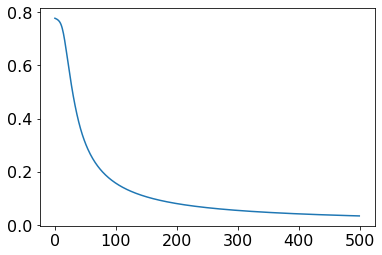

In [271]:
plt.figure()
plt.plot(custom_history.history['loss'])

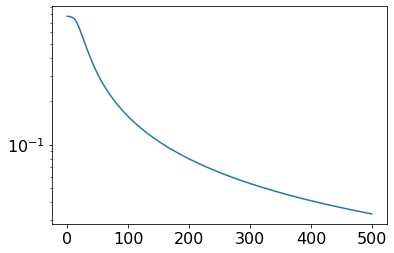

In [272]:
plt.figure()
plt.plot(custom_history.history['loss'])
plt.yscale('log')

In [273]:
custom_yhat = custom_model.predict(X_train)

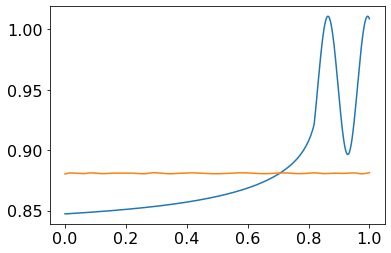

In [274]:
plt.figure()
plt.plot(X_train, Y_train)
plt.plot(X_train, custom_yhat)

# loss w.r.t just derivative where the derivative is computed in the train step

In [73]:
loss_tracker = tf.keras.metrics.Mean(name="loss")

class CustomModel_deriv(tf.keras.Model):

    def train_step(self, data):
        # Unpack the data. Its structure depends on your model and
        # on what you pass to `fit()`.
#         x, y = data
#         tf.print(y)
        x, dy = data
#         tf.print(ys)
#         tf.print(ys[...,0])
#         tf.print(ys[...,1])
#         y = ys
#         dy = ys[...,1]
        
#         tf.print(y)

        with tf.GradientTape() as tape:
            d_y_pred = self(x, training=True)  # Forward pass
            

            # Compute the loss value
            # (the loss function is configured in `compile()`)
            
            # derivative of prediction
#             d_y_pred = self.compute_gradient_from_model(x)
            
            loss_y = tf.keras.losses.mean_squared_error(y, y_pred)
#             loss_dy = tf.keras.losses.mean_squared_error(dy, d_y_pred)
            
#             loss = loss_y + loss_dy
#             loss = loss_y
            loss = loss_dy
            

        # Compute gradients
        trainable_vars = self.trainable_variables
        gradients = tape.gradient(loss, trainable_vars)
        # Update weights
        self.optimizer.apply_gradients(zip(gradients, trainable_vars))

        # Compute our own metrics
        loss_tracker.update_state(loss)
        return {"loss": loss_tracker.result()}
    
    

In [74]:
def build_custom_model_deriv(input_shape, output_shape, units, activation, n_hidden_layers):
    
    input_layer = tf.keras.Input(shape=(input_shape,))
    x = input_layer
    for i in range(n_hidden_layers):
        x = tf.keras.layers.Dense(units, activation=activation)(x)
    output_layer = tf.keras.layers.Dense(output_shape)(x)
    
    return CustomModel_deriv(inputs=input_layer, outputs=output_layer)

In [75]:
custom_model_deriv_params = dict(
    input_shape=1,
    output_shape=1,
    units=128,
    activation='s2relu',
    n_hidden_layers=4)

In [76]:
custom_model_deriv = build_custom_model_deriv(**custom_model_deriv_params)

In [77]:
custom_model_deriv.compile(optimizer=tf.keras.optimizers.Adam(1e-3), loss='mse')

In [78]:
# 1st col = y
# 2nd col = dy
# Y_train_new = np.column_stack((Y_train, dy_train))
# Y_train_new = Y_train.copy()
Y_train_new = dy_train.copy()

In [79]:
Y_train_new.shape

(1219, 1)

In [80]:
dy_train.shape

(1219, 1)

In [81]:
%%time
custom_deriv_history = custom_model_deriv.fit(X_train, Y_train_new, epochs=1, verbose=0, batch_size=1219)

CPU times: user 335 ms, sys: 25.6 ms, total: 360 ms
Wall time: 318 ms
